<a href="https://colab.research.google.com/github/maressakaren/Analise_de_dados/blob/main/Reconhecimento_de_emocoes_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun 27 19:42:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    30W /  70W |   3901MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install datasets
!pip install emoji
!pip install transformers
!pip install accelerate

!python -m spacy download pt_core_news_sm

In [ ]:
import spacy
import re
import numpy as np
import matplotlib.pyplot as plt
import emoji
import os
import torch
import torch.nn.functional as f

from datasets import load_dataset
from unicodedata import normalize
from tqdm import tqdm
from collections import Counter
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [ ]:
dataset = load_dataset("dair-ai/emotion")

dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
n_rows = -1

tweets_train = dataset['train']['text']
tweets_validation = dataset['validation']['text']
tweets_test = dataset['test']['text']

labels_train = dataset['train']['label']
labels_validation = dataset['validation']['label']
labels_test = dataset['test']['label']

if n_rows > 0:
  tweets_train = tweets_train[:n_rows]
  tweets_validation = tweets_validation[:n_rows]
  tweets_test = tweets_test[:n_rows]

  labels_train = labels_train[:n_rows]
  labels_validation = labels_validation[:n_rows]
  labels_test = labels_test[:n_rows]

print(f'\nTrain: {len(tweets_train)}')
print(f'Validation: {len(tweets_validation)}')
print(f'Test: {len(tweets_test)}')

print(f'\n\nLabels Distribution Train: {Counter(labels_train)}')
print(f'Labels Distribution Validation: {Counter(labels_validation)}')
print(f'Labels Distribution Test: {Counter(labels_test)}')

print(f'\n\nRaw Tweet Train: {tweets_train[0]}')
print(f'Raw Tweet Validation: {tweets_validation[0]}')
print(f'Raw Tweet Test: {tweets_test[0]}')

In [ ]:
def preprocessar_tweets(tweets):
    repetion_pattern = re.compile(r'(.)\1\1+')
    new_tweets = []
    with tqdm(total=len(tweets), colour='green', desc='Processando') as pbar:
      for tweet in tweets:
          tweet = emoji.demojize(tweet, language='pt')
          tweet = tweet.replace('_', ' ')
          tweet = normalize('NFKD', tweet).encode('ASCII', 'ignore').decode('ASCII')
          tweet = repetion_pattern.sub(r'\1', tweet)
          tweet = re.sub(r'https?://\w+', '', tweet)
          tweet = re.sub(r'@\w+', ' ', tweet)
          tweet = re.sub(r'\s\s+', ' ', tweet)
          new_tweets.append(tweet.strip())
          pbar.update(1)
    return new_tweets

In [ ]:
tweets_train = preprocessar_tweets(tweets_train)
tweets_validation = preprocessar_tweets(tweets_validation)
tweets_test = preprocessar_tweets(tweets_test)

print(f'\n\nPreprocessed Tweet Train: {tweets_train[0]}')
print(f'Preprocessed Tweet Validation: {tweets_validation[0]}')
print(f'Preprocessed Tweet Test: {tweets_test[0]}')

In [ ]:
model_name = 'distilbert'
# model_name = 'bert_base'
# model_name = 'bertabaporu'

num_classes = 6

if model_name == 'distilbert':
  model_path = 'adalbertojunior/distilbert-portuguese-cased'
elif model_name == 'bert_base':
  model_path = 'neuralmind/bert-base-portuguese-cased'
elif model_name == 'bertabaporu':
  model_path = 'pablocosta/bertabaporu-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_path)

model = BertForSequenceClassification.from_pretrained(model_path, num_labels=num_classes)

print(model)

print(f'\n\nNúmero de Parâmetros: {model.num_parameters():,}')

In [ ]:
y_train = torch.tensor(labels_train)
y_val = torch.tensor(labels_validation)
y_test = torch.tensor(labels_test)

y_train = f.one_hot(y_train, num_classes=num_classes)
y_val = f.one_hot(y_val, num_classes=num_classes)
y_test = f.one_hot(y_test, num_classes=num_classes)

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

device

'cuda'

In [ ]:
train_dict = {'text': tweets_train, 'label': y_train}
val_dict = {'text': tweets_validation, 'label': y_val}
test_dict = {'text': tweets_test, 'label': y_test}

train_dataset = Dataset.from_dict(train_dict)
val_dataset = Dataset.from_dict(val_dict)
test_dataset = Dataset.from_dict(test_dict)

In [ ]:
def tokenize_tweet(example, tokenizer, max_len):
  return tokenizer(example['text'], padding='max_length', max_length=max_len, truncation=True)

In [ ]:
max_len = 150
batch_size = 32

encoded_train_dataset = train_dataset.map(lambda t: tokenize_tweet(t, tokenizer, max_len), \
                                  batched=True, batch_size=batch_size)

encoded_val_dataset = val_dataset.map(lambda t: tokenize_tweet(t, tokenizer, max_len), \
                                      batched=True, batch_size=batch_size)

encoded_test_dataset = test_dataset.map(lambda t: tokenize_tweet(t, tokenizer, max_len),
                                        batched=True, batch_size=batch_size)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
def computar_medidas_eval(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  labels = np.argmax(labels, axis=-1)
  acc = accuracy_score(labels, predictions)
  return {
      'acc': acc
  }

In [ ]:
num_epochs = 7

training_args = TrainingArguments(output_dir='training/', num_train_epochs=num_epochs,
                                  weight_decay=0.01,
                                  learning_rate=5e-5,
                                  optim='adamw_torch',
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  logging_steps=100, eval_steps=100,
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch', load_best_model_at_end=True,
                                  metric_for_best_model='acc', greater_is_better=True)

trainer = Trainer(model=model, args=training_args, train_dataset=encoded_train_dataset,
                  eval_dataset=encoded_val_dataset, compute_metrics=computar_medidas_eval,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Acc
1,0.209800,0.177938,0.779500
2,0.090700,0.096765,0.896000
3,0.056700,0.086775,0.909500
4,0.045600,0.071609,0.913500
5,0.034800,0.079077,0.913000
6,0.027800,0.092538,0.913000
7,0.021200,0.093590,0.916000
8,0.014700,0.100648,0.919000
9,0.009900,0.104954,0.918500
10,0.011300,0.107596,0.920000


TrainOutput(global_step=5000, training_loss=0.06685472795963288, metrics={'train_runtime': 2112.9151, 'train_samples_per_second': 75.725, 'train_steps_per_second': 2.366, 'total_flos': 6209852256000000.0, 'train_loss': 0.06685472795963288, 'epoch': 10.0})

In [ ]:
y_pred, _, _ = trainer.predict(encoded_test_dataset)

y_pred = np.argmax(y_pred, axis=-1)

y_pred = [y for y in y_pred]

In [ ]:
report = classification_report(labels_test, y_pred, zero_division=0)

print(report)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       581
           1       0.93      0.94      0.94       695
           2       0.82      0.77      0.79       159
           3       0.90      0.91      0.90       275
           4       0.88      0.86      0.87       224
           5       0.69      0.70      0.69        66

    accuracy                           0.91      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.91      0.91      0.91      2000



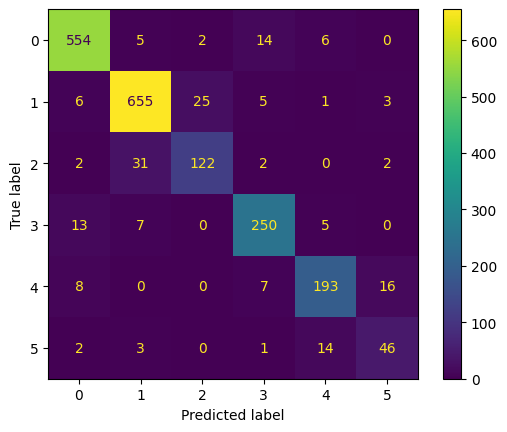

In [ ]:
ConfusionMatrixDisplay.from_predictions(labels_test, y_pred)

plt.show()